In [188]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = "/Volumes/GoogleDrive/Meine Ablage/Dokumente/1 - Schule/1 - ETHZ/9. Semester/Master Thesis/thesis/img"

In [189]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [190]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

In [191]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    # For very small values, caused by clock skew
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [192]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

# Experiments

In [193]:
experiments = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis": os.path.join(BASE_PATH, "redis"),
    "Direct": os.path.join(BASE_PATH, "nat")
}


## P2P

### Variance

ShapiroResult(statistic=0.24865847826004028, pvalue=2.674668962085895e-20)
S3
222.2
ShapiroResult(statistic=0.9526926875114441, pvalue=0.0012534911511465907)
Redis
13.5
ShapiroResult(statistic=0.9268631339073181, pvalue=3.318036760902032e-05)
Direct
10.0
ShapiroResult(statistic=0.7951151132583618, pvalue=1.7577431177251412e-10)
Direct (UDT)
2593.7


<ipython-input-194-89d0a4d57ecb>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


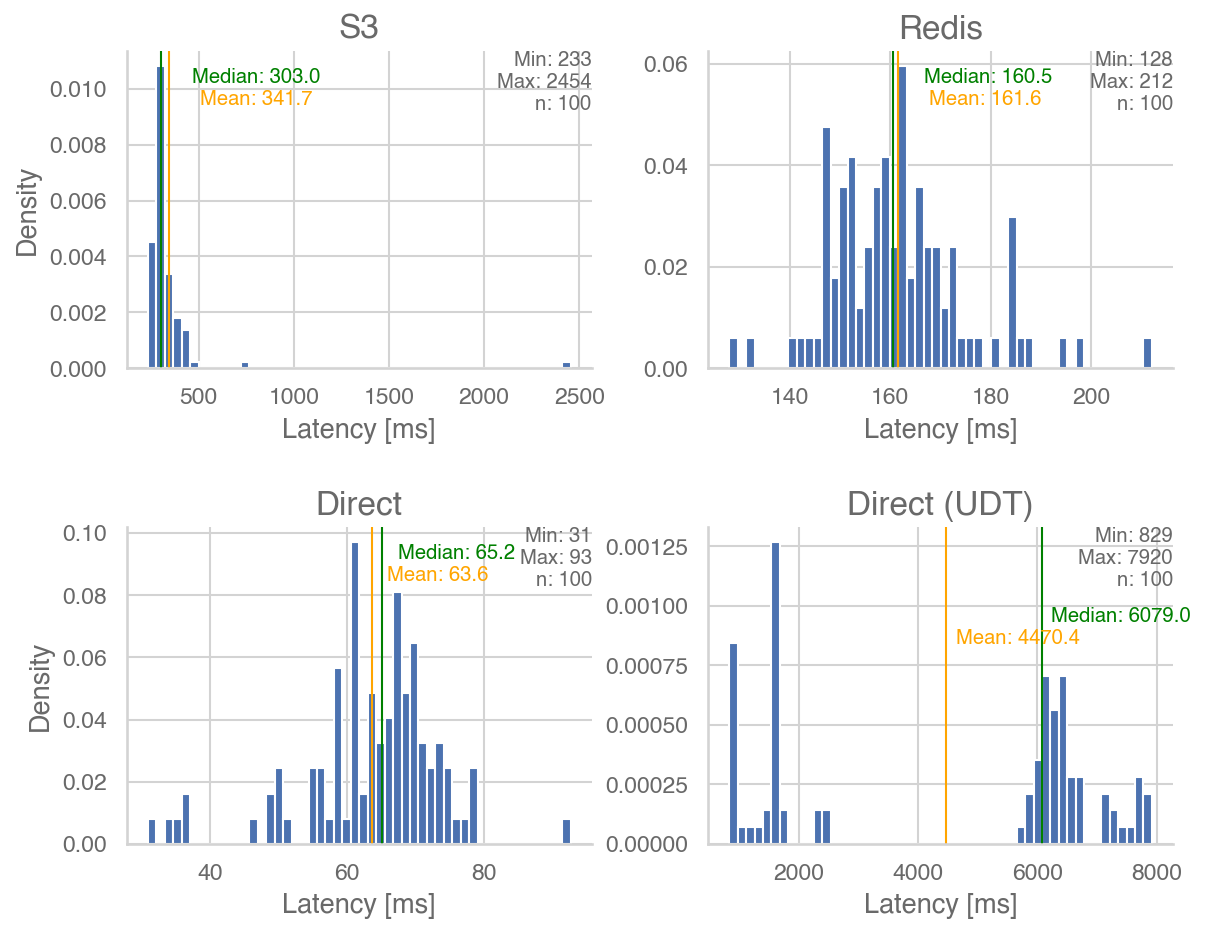

In [194]:
fig = plt.figure(figsize=(9,7))
gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1]))
i = 0
exp_analysis = experiments.copy()
exp_analysis["Direct (UDT)"] = os.path.join(BASE_PATH, "nat")
for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out_udt")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = list(deltas[10000000].values())
    print(scipy.stats.shapiro(delta_vals))
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    std = np.std(delta_vals)
    print(experiment_name)
    print(round(std, 1))
    median = np.median(delta_vals)
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Latency [ms]")
    if i == 0 or i ==2:
        ax.set_ylabel("Density")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    y_offset_1 = 0.9
    y_offset_2 = 0.83
    if experiment_name == "Direct (UDT)":
        offset = (max_xlim - min_xlim) / 50
        y_offset_1 = 0.7
        y_offset_2 = 0.63
    if experiment_name == "Direct":
        offset = (max_xlim - min_xlim) / 30
    ax.text(median + offset, max_ylim*y_offset_1, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*y_offset_2, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance.pdf"))

### Performance

{0.001: 2.666666666666667e-05, 1.0: 0.02127659574468085, 10.0: 0.2564102564102564, 100.0: 2.197802197802198, 1000.0: 9.174311926605503, 10000.0: 37.17472118959108, 100000.0: 53.951982735365526, 500000.0: 45.674614049511284}
{0.001: 0.0005, 1.0: 0.6666666666666666, 10.0: 4.0, 100.0: 8.333333333333334, 1000.0: 19.801980198019802, 10000.0: 52.35602094240838, 100000.0: 96.15384615384616, 500000.0: 46.4921660700172}
{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846, 500000.0: 109.31218377427696}
{0.001: 1.2870012870012869e-06, 1.0: 0.0014566642388929353, 10.0: 0.018957345971563982, 100.0: 0.05124263387138099, 1000.0: 0.191131498470948, 10000.0: 1.8501387604070305, 100000.0: 11.83361931246672, 500000.0: 32.22687721559781}


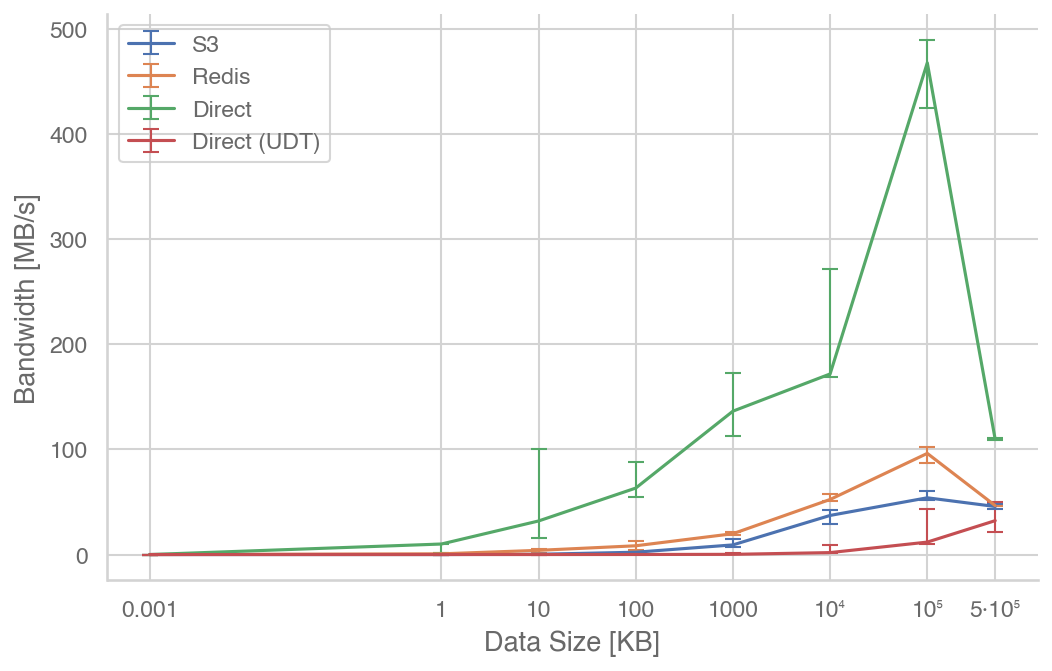

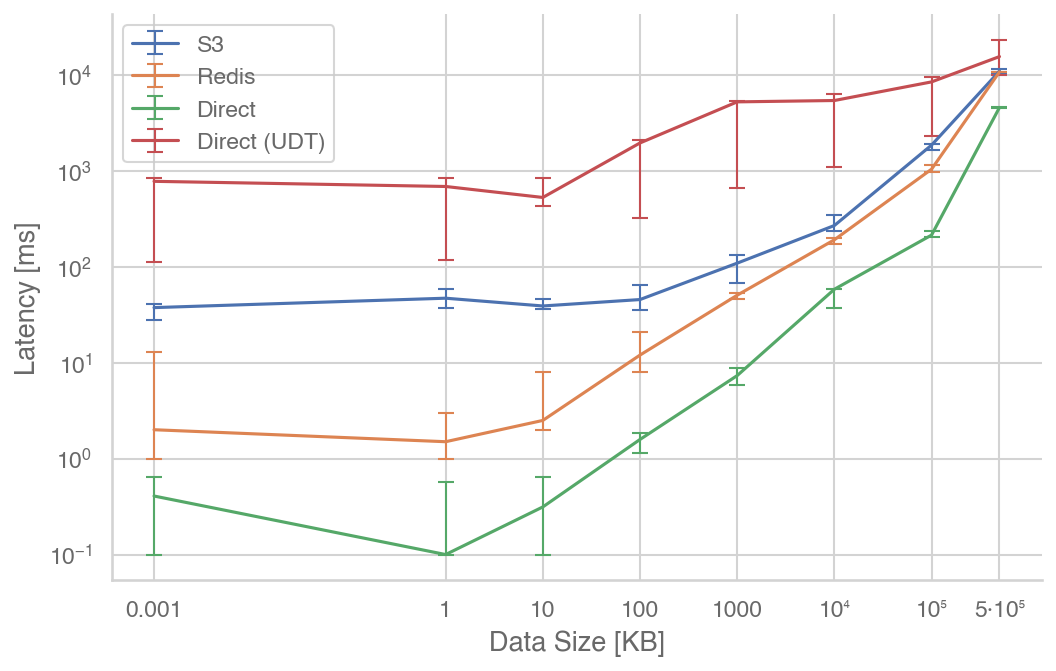

In [195]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = experiments.copy()
exp_analysis["Direct (UDT)"] = os.path.join(BASE_PATH, "nat")
for experiment_name, exp_base_path in exp_analysis.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_udt")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        p2p_experiment_means[experiment_name][file_size / 1000] = mean
        p2p_experiment_cis[experiment_name][file_size / 1000] = ci
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Latency [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_bandwidth.pdf"))
fig2.savefig(os.path.join(OUTPUT_PATH, "p2p_latency.pdf"))
plt.show()





## One to Many

### Variance

63.7
66.6
62.2


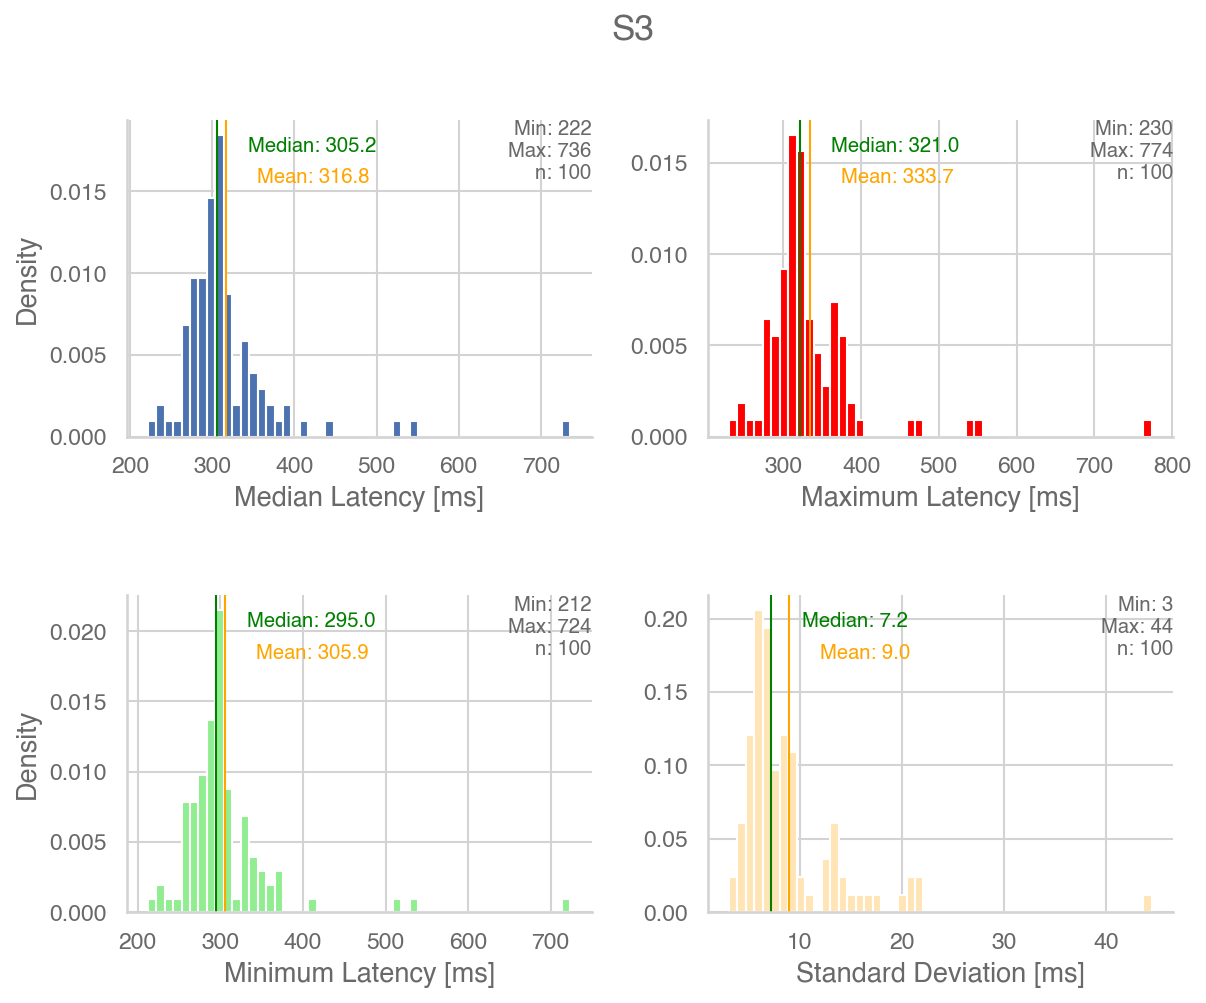

25.1
60.8
25.1


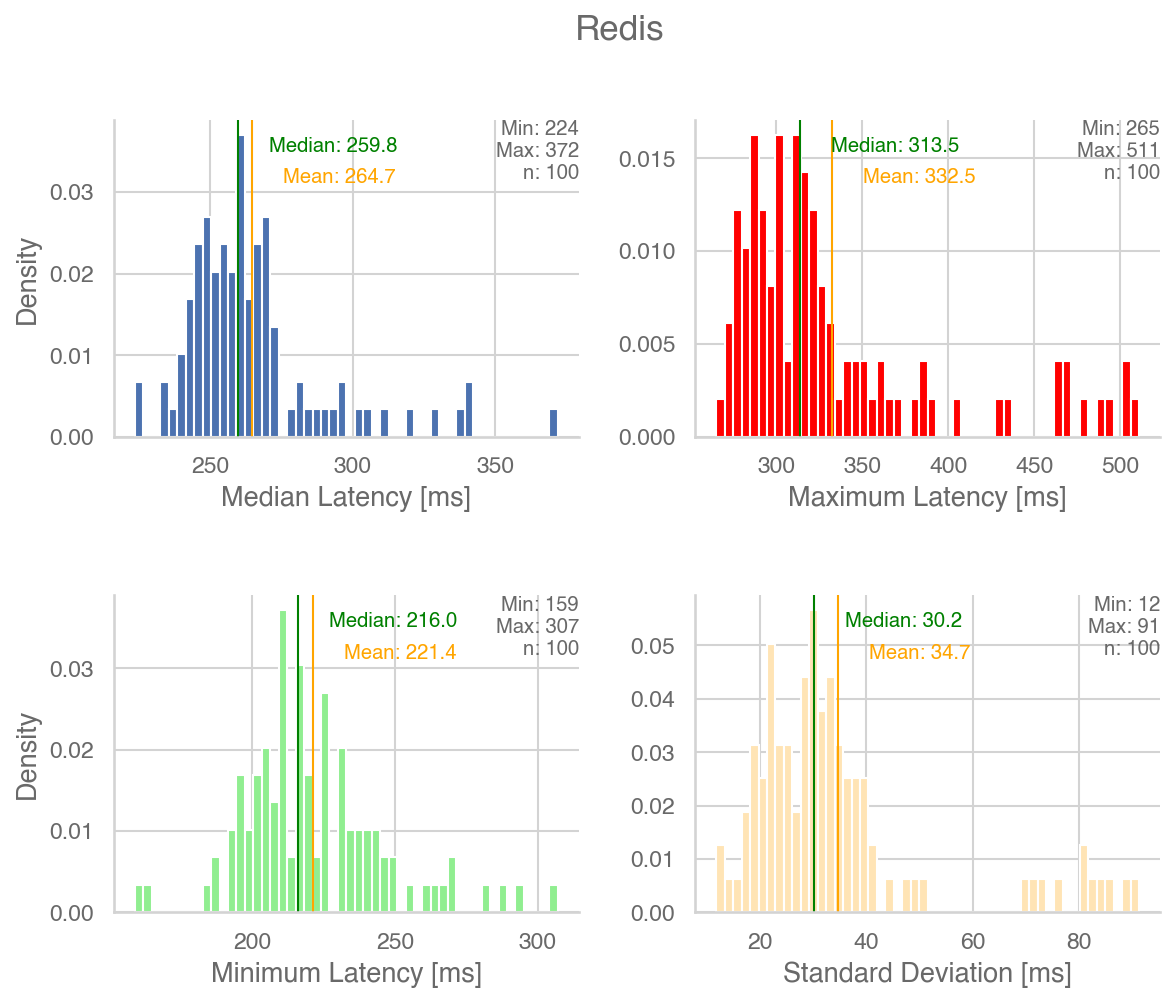

26.6
35.4
15.3


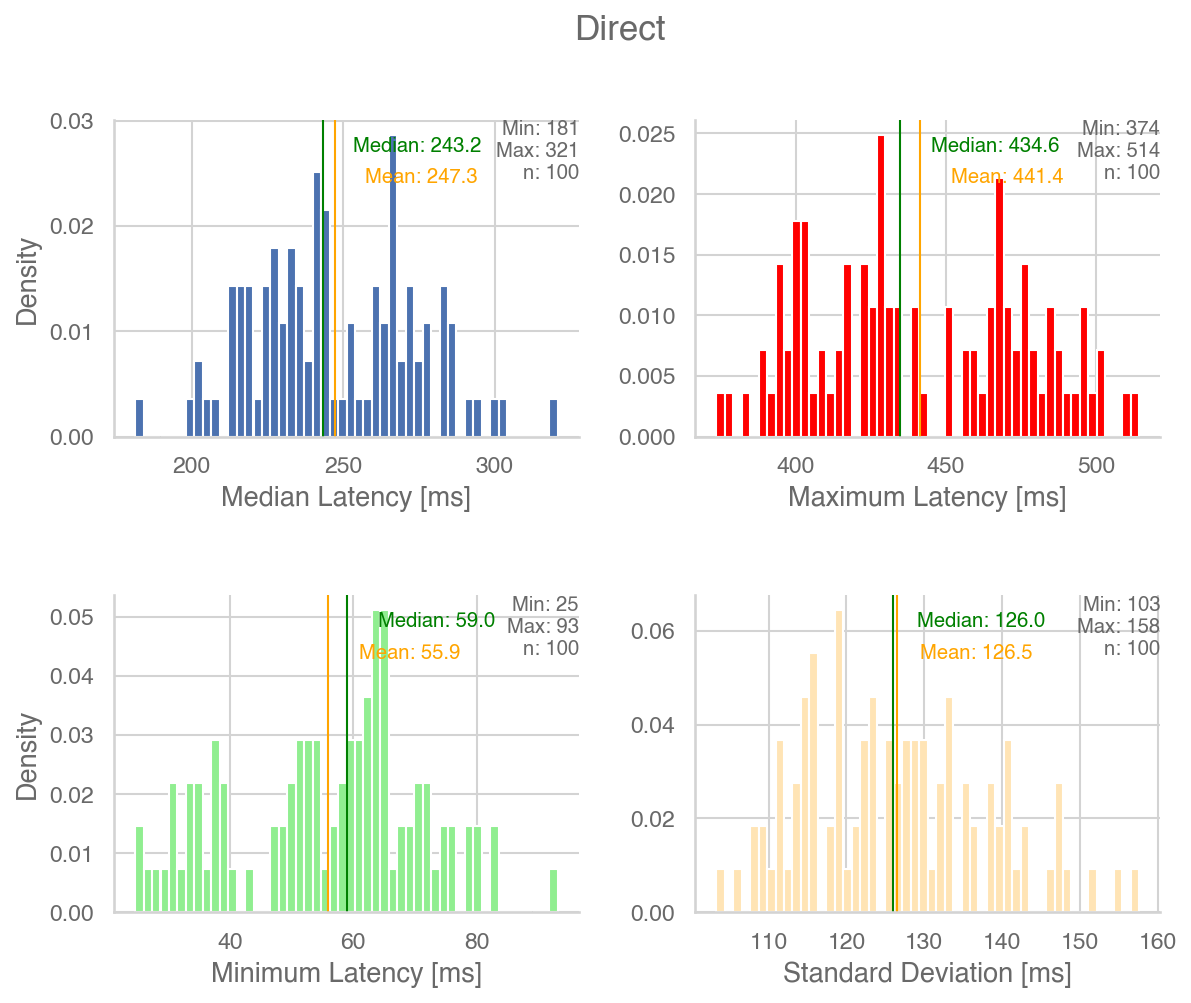

In [196]:
for experiment_name, exp_base_path in experiments.items():
    fig = plt.figure(figsize=(9,7))
    fig.suptitle(experiment_name)
    gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.5) # 2x2 grid
    axes = []
    axes.append(fig.add_subplot(gs[0, 0]))
    axes.append(fig.add_subplot(gs[0, 1]))
    axes.append(fig.add_subplot(gs[1, 0]))
    axes.append(fig.add_subplot(gs[1, 1]))

    var_base_path = os.path.join(exp_base_path, "one_to_many", "latency_distribution", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    all_delta_vals = list(deltas[10000000].values())
    delta_vals = [np.median(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    median = np.median(delta_vals)

    ax = axes[0]
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Median Latency [ms]")
    ax.set_ylabel("Density")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    print(round(np.std(delta_vals), 1))
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    if experiment_name == "Direct":
        offset = 10
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.max(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    print(round(np.std(delta_vals), 1))
    median = np.median(delta_vals)
    ax = axes[1]
    ax.hist(delta_vals, density=True, bins=50, color="red")
    ax.set_xlabel("Maximum Latency [ms]")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.min(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    print(round(np.std(delta_vals), 1))
    median = np.median(delta_vals)
    ax = axes[2]
    ax.hist(delta_vals, density=True, bins=50, color="lightgreen")
    ax.set_xlabel("Minimum Latency [ms]")
    ax.set_ylabel("Density")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')


    delta_vals = [np.std(run_vals) for run_vals in all_delta_vals]
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    median = np.median(delta_vals)
    ax = axes[3]
    ax.hist(delta_vals, density=True, bins=50, color="moccasin")
    ax.set_xlabel("Standard Deviation [ms]")
    ax.axvline(mean, color='orange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    if experiment_name == "Direct":
        offset = (max_xlim - min_xlim) / 20
    ax.text(median + offset, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
    ax.text(mean + offset, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
    fig.savefig(os.path.join(OUTPUT_PATH, "{}_one-to-many_variance.pdf".format(experiment_name)))


    
    plt.show()

### Performance

{0.001: 62.0, 1.0: 65.5, 10.0: 81.0, 100.0: 81.5, 1000.0: 157.5, 10000.0: 323.0, 100000.0: 1930.0, 500000.0: 10920.5}
{0.001: 15.0, 1.0: 23.5, 10.0: 20.5, 100.0: 27.5, 1000.0: 48.0, 10000.0: 298.0, 100000.0: 2630.5, 500000.0: 83179.5}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625, 500000.0: 49453.80090332031}


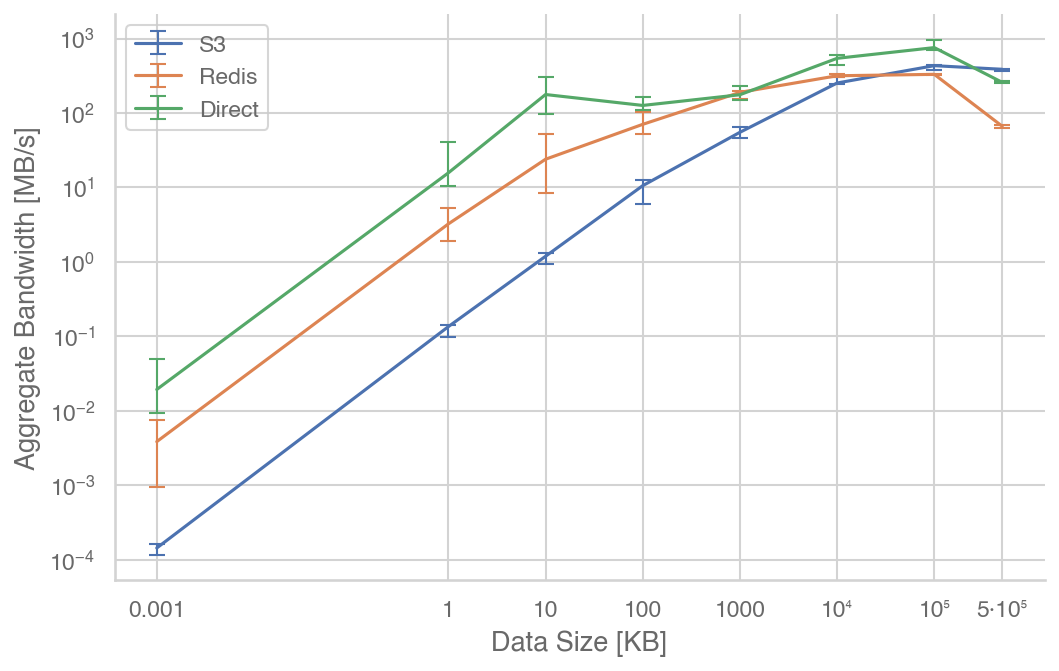

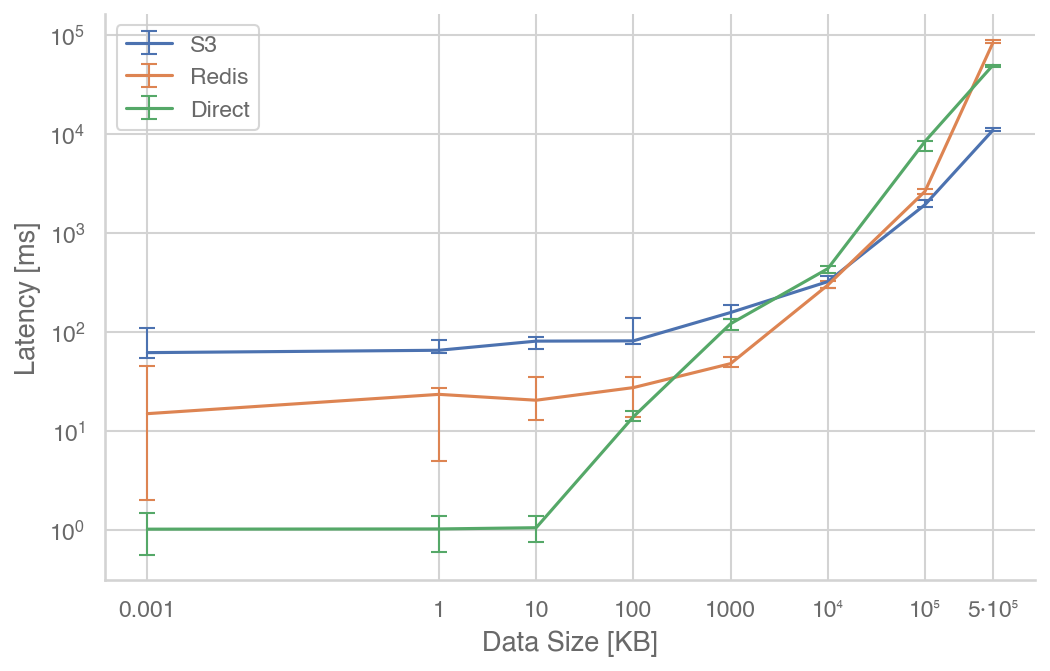

In [197]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_performance_means = {}
one_to_many_performance_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_performance_means[experiment_name] = {}
    one_to_many_performance_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_data", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        values = list(deltas[file_size].values())
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += file_size / latency / 1000
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        values = list(deltas[file_size].values())
        run_means = []
        run_latencies = []
        for run_arr in values:
            run_latencies.append(np.max(run_arr))
            run_means.append(np.mean(run_arr))
        val = np.median(run_latencies)
        one_to_many_performance_means[experiment_name][file_size / 1000] = np.mean(run_means)
        one_to_many_performance_cis[experiment_name][file_size / 1000] = scipy.stats.sem(run_means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(run_means) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(run_latencies)[-2] - val
        lower_ci = val - np.sort(run_latencies)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Latency [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_bandwidth.pdf"))
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_latency.pdf"))
plt.show()

### Scalability

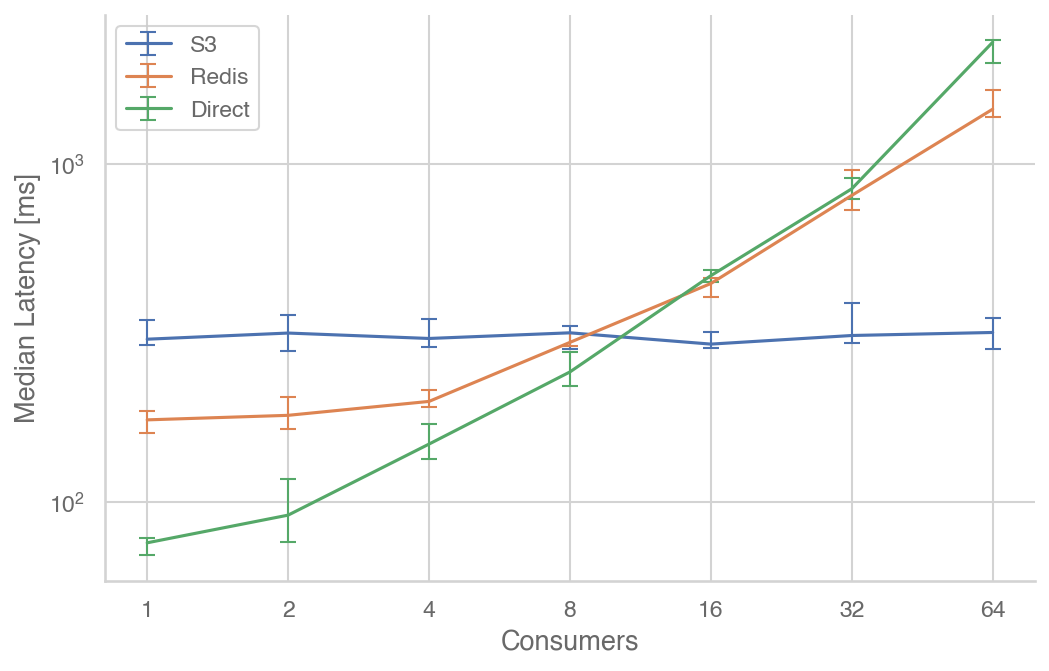

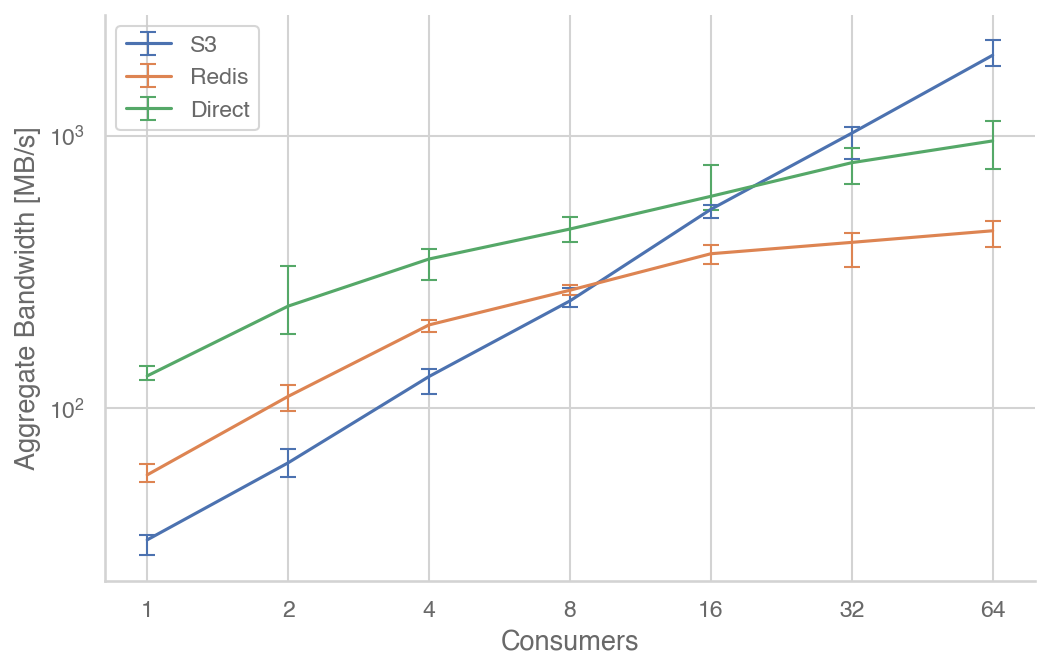

In [198]:
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_scalability_means = {}
one_to_many_scalability_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_scalability_means[experiment_name] = {}
    one_to_many_scalability_cis[experiment_name] = {}
    experiment_base_folder = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out")
    plot_data = {}
    plot_data_bw = {}
    lower_error = []
    upper_error = []
    lower_error_bw = []
    upper_error_bw = []
    num_lambdas = []
    for subf in os.scandir(experiment_base_folder):
        if subf.name != "256" and subf.name != "128":
            num_lambdas.append(int(subf.name))
    for num_lambda in sorted(num_lambdas):    
        var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out", str(num_lambda))
        res = parse_json(var_base_path)
        deltas = calc_deltas(res)
        run_medians = [np.median(run_data) for run_data in deltas[10000000].values()]
        plot_data[num_lambda] = np.median(run_medians)
        lower_error.append(np.median(run_medians) - np.sort(run_medians)[1])
        upper_error.append(np.sort(run_medians)[-2] - np.median(run_medians))

        values = list(deltas[10000000].values())
        means = [np.mean(run) for run in values]
        one_to_many_scalability_means[experiment_name][num_lambda] = np.mean(means)
        one_to_many_scalability_cis[experiment_name][num_lambda] = scipy.stats.sem(means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(means) - 1)
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += 10 / (latency / 1000)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data_bw[num_lambda] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error_bw.append(lower_ci)
        upper_error_bw.append(upper_ci)

    ax.set_xscale('log')
    ax.set_xlabel("Consumers")
    ax.set_xticks(list(plot_data.keys()))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel("Median Latency [ms]")
    ax.set_yscale("log")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    ax2.set_xscale('log')
    ax2.set_xlabel("Consumers")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data_bw.keys(), plot_data_bw.values(), [lower_error_bw, upper_error_bw], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_latency.pdf"))
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_bw.pdf"))
plt.show()

# Cost

In [199]:
# AWS eu-central-1 values
p_faas = 0.0000166667
p_vm = 0.0134
p_kv = 0.038
p_d = 0.00043 / 1000
p_u = 0.0054 / 1000

In [200]:
def calc_lambda_cost(P, C, t, R, M):
    return (P + C) * t * R * p_faas * M

def calc_s3_cost(P, C, R, g):
    c_up = P * R * p_u
    c_down = C * P * R * g * p_d
    return c_up + c_down

def calc_redis_cost(R, r):
    return R / r * p_kv

def calc_direct_cost(R, r):
    return R / r * p_vm

## P2P

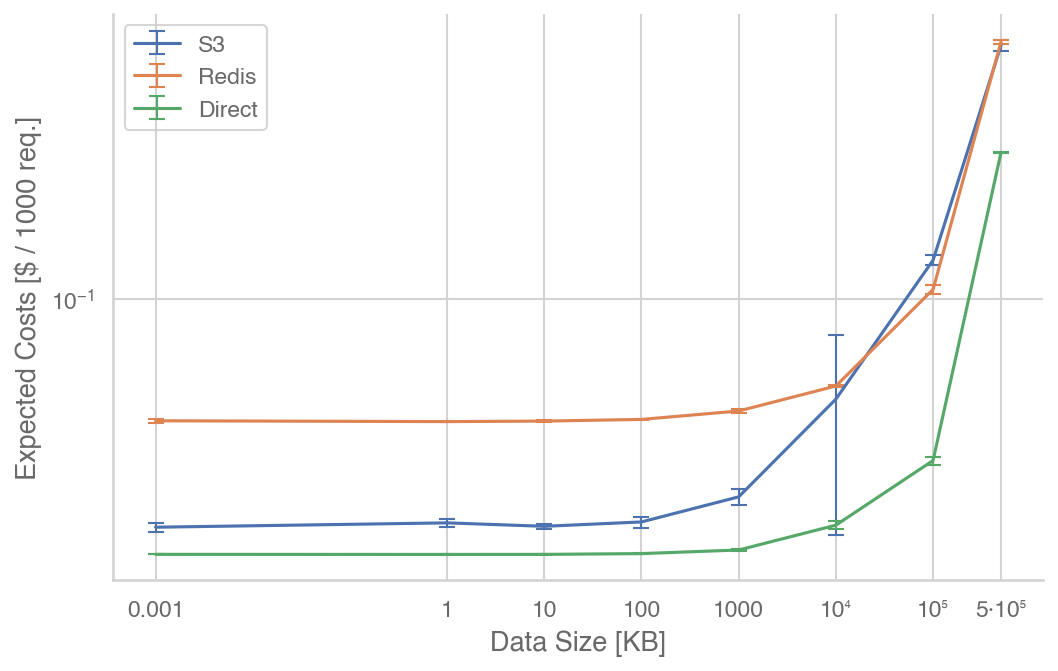

In [201]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Data Size [KB]")
ax.set_ylabel("Expected Costs [$ / 1000 req.]")
ax.set_xticks(list(p2p_experiment_means["S3"].keys()))
ax.set_xticklabels(format_xticks(p2p_experiment_means["S3"].keys()))
for experiment_name, means in p2p_experiment_means.items():
    if experiment_name == "Direct (UDT)":
        continue
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        mean_lb = mean - p2p_experiment_cis[experiment_name][file_size]
        mean_ub = mean + p2p_experiment_cis[experiment_name][file_size]
        c_faas = calc_lambda_cost(1, 1, mean / 1000, R, 2)
        c_faas_lb = calc_lambda_cost(1, 1, mean_lb / 1000, R, 2)
        c_faas_ub = calc_lambda_cost(1, 1, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_s3_cost(1, 1, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_redis_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[file_size] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_costs.pdf"))
plt.show()

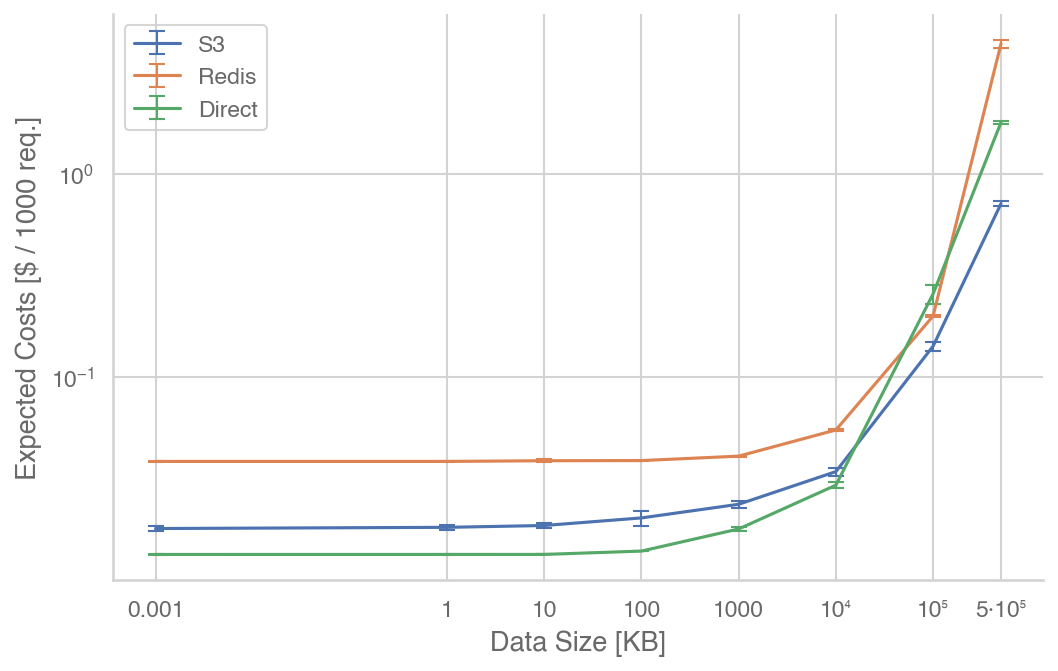

In [202]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Data Size [KB]")
ax.set_ylabel("Expected Costs [$ / 1000 req.]")
ax.set_xticks(list(one_to_many_performance_means["S3"].keys()))
ax.set_xticklabels(format_xticks(one_to_many_performance_means["S3"].keys()))
for experiment_name, means in one_to_many_performance_means.items():
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        mean_lb = mean - one_to_many_performance_cis[experiment_name][file_size]
        mean_ub = mean + one_to_many_performance_cis[experiment_name][file_size]
        c_faas = calc_lambda_cost(1, 1, mean / 1000, R, 2)
        c_faas_lb = calc_lambda_cost(1, 1, mean_lb / 1000, R, 2)
        c_faas_ub = calc_lambda_cost(1, 1, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_s3_cost(1, 1, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_redis_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[file_size] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_performance_costs.pdf"))
plt.show()

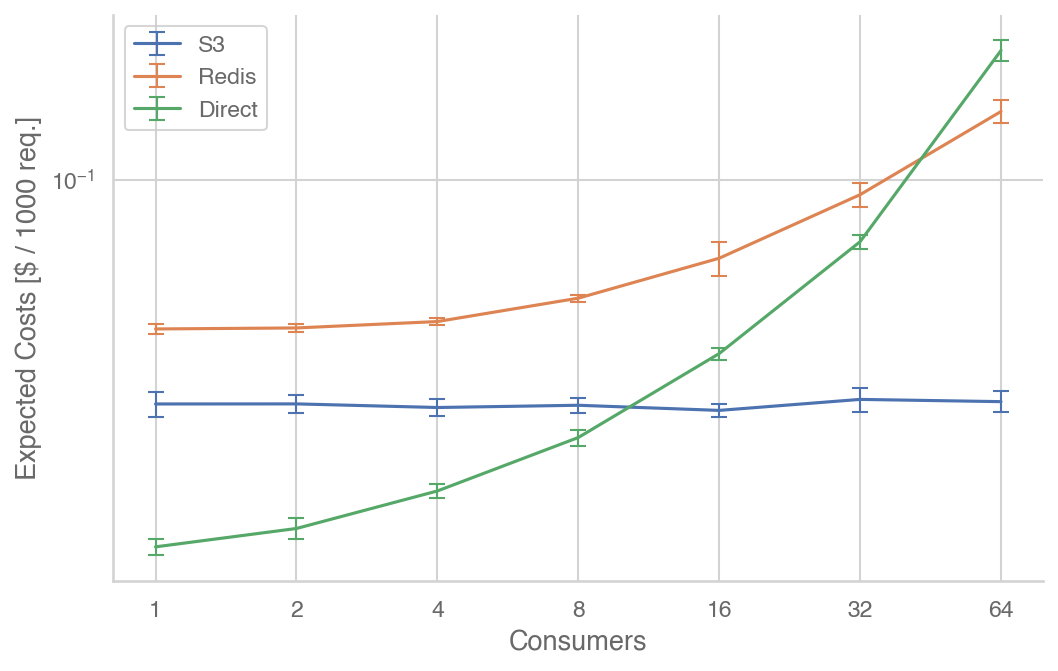

In [203]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Consumers")
ax.set_ylabel("Expected Costs [$ / 1000 req.]")
ax.set_xticks(list(one_to_many_scalability_means["S3"].keys()))
ax.set_xticklabels(format_xticks(one_to_many_scalability_means["S3"].keys()))
for experiment_name, means in one_to_many_scalability_means.items():
    R = 1000
    r = 1000
    g = 20
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        mean_lb = mean - one_to_many_scalability_cis[experiment_name][file_size]
        mean_ub = mean + one_to_many_scalability_cis[experiment_name][file_size]
        c_faas = calc_lambda_cost(1, 1, mean / 1000, R, 2)
        c_faas_lb = calc_lambda_cost(1, 1, mean_lb / 1000, R, 2)
        c_faas_ub = calc_lambda_cost(1, 1, mean_ub / 1000, R, 2)
        if experiment_name == "S3":
            c_channel = calc_s3_cost(1, 1, R, g)
        elif experiment_name == "Redis":
            c_channel = calc_redis_cost(R, r)
        elif experiment_name == "Direct":
            c_channel = calc_direct_cost(R, r)
        plot_data[file_size] = c_faas + c_channel
        upper_error.append(c_faas_ub - c_faas)
        lower_error.append(c_faas - c_faas_lb)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_costs.pdf"))
plt.show()

# Performance Model

## Bandwidth Scaling, Single Consumer

0.73
0.0
0.68
0.93
0.65
0.89


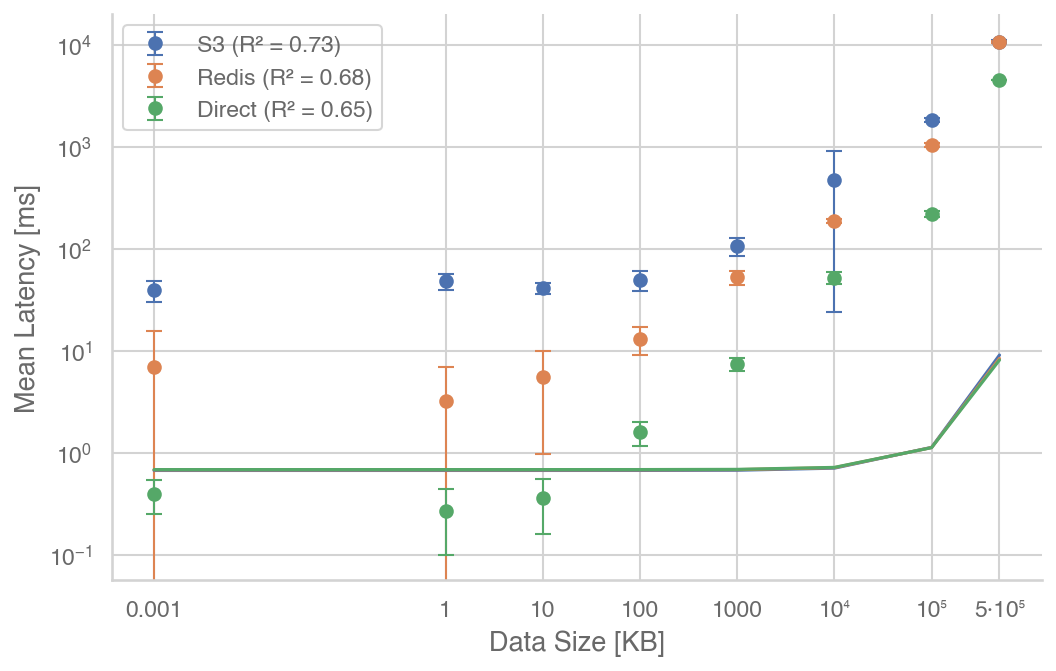

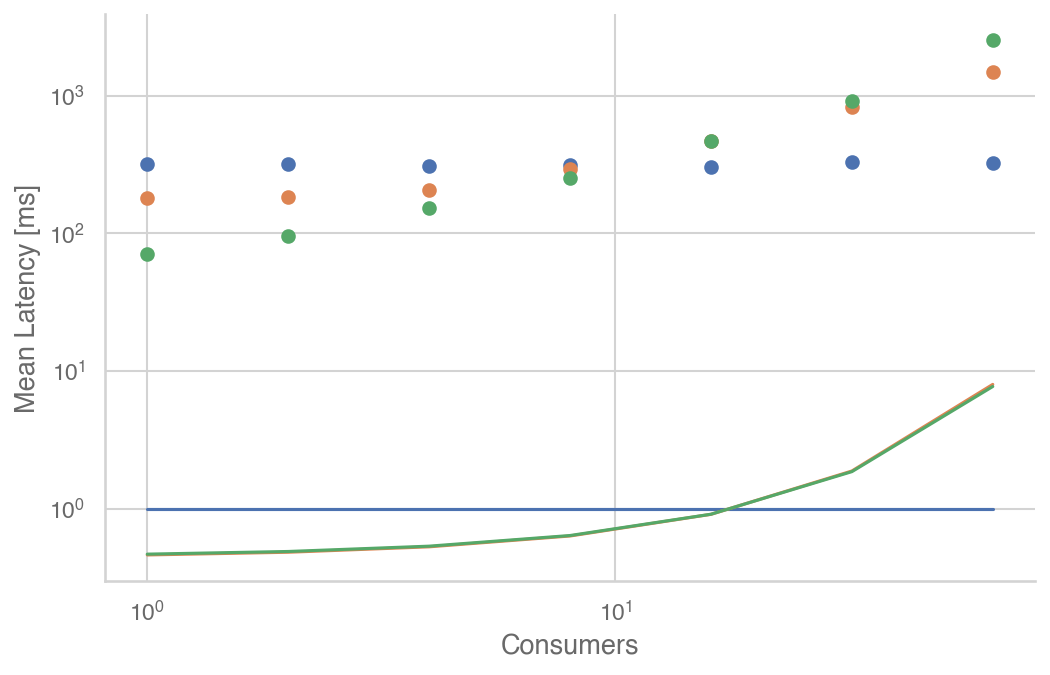

In [235]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Data Size [KB]")
ax.set_ylabel("Mean Latency [ms]")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Consumers")
ax2.set_ylabel("Mean Latency [ms]")
ax.set_xticks(list(p2p_experiment_means["S3"].keys()))
ax.set_xticklabels(format_xticks(p2p_experiment_means["S3"].keys()))
i = 0
regs = {}
intercepts = {}
for experiment_name, means in p2p_experiment_means.items():
    if experiment_name == "Direct (UDT)":
        continue
    plot_data = {}
    lower_error, upper_error = [], []
    for file_size, mean in means.items():
        mean_lb = mean - p2p_experiment_cis[experiment_name][file_size]
        mean_ub = mean + p2p_experiment_cis[experiment_name][file_size]
        plot_data[file_size] = mean
        upper_error.append(mean_ub - mean)
        lower_error.append(mean - mean_lb)
    multiple_data = {}
    for num_lambda, mean in one_to_many_scalability_means[experiment_name].items():
        multiple_data[num_lambda] = mean
    intercept = np.mean([plot_data[0.001], plot_data[1], plot_data[10]])
    if experiment_name == "S3":
        X_single = [[x, 0] for x in plot_data.keys()]
    else:
        X_single = [[x, 1] for x in plot_data.keys()]
    y_single = [np.log(y) for y in plot_data.values()]
    if experiment_name == "S3":
        X_multiple = [[10000.0, 0] for num_lambda in multiple_data.keys()]
    else:
        X_multiple = [[10000.0, num_lambda] for num_lambda in multiple_data.keys()]
    y_multiple = []
    for num_lambda, y in multiple_data.items():
        y_multiple.append(np.log(y))
    
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=True)
    from sklearn.preprocessing import StandardScaler
    X_single_scaled = StandardScaler().fit_transform(X_single)
    X_multiple_scaled = StandardScaler().fit_transform(X_multiple)
    y_single_scaled = StandardScaler().fit_transform(np.array(y_single).reshape(-1,1))
    y_multiple_scaled = StandardScaler().fit_transform(np.array(y_multiple).reshape(-1,1))
    
    X_single_trans = poly.fit_transform(X_single_scaled)
    X_multiple_trans = poly.fit_transform(X_multiple_scaled)
    reg = LinearRegression(fit_intercept=False).fit(np.concatenate((X_single_trans, X_multiple_trans)), np.concatenate((y_single_scaled, y_multiple_scaled)))
    regs[experiment_name] = reg
    intercepts[experiment_name] = intercept
    r2_single = round(reg.score(X_single_trans, y_single_scaled), 2)
    r2_multiple = round(reg.score(X_multiple_trans, y_multiple_scaled), 2)
    print(r2_single)
    print(r2_multiple)
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label="{} (R² = {})".format(experiment_name, r2_single), fmt='o', color='C{}'.format(i))
    ax.plot(plot_data.keys(), np.power(np.e, reg.predict(X_single_trans)))
    ax2.scatter(multiple_data.keys(), multiple_data.values())
    ax2.plot(multiple_data.keys(), np.power(np.e, reg.predict(X_multiple_trans)))
    i += 1
    
ax.legend()
#fig.savefig(os.path.join(OUTPUT_PATH, "p2p_costs.pdf"))
plt.show()

0.2588448346503148
0.16355910404253327
0.24428344093322474


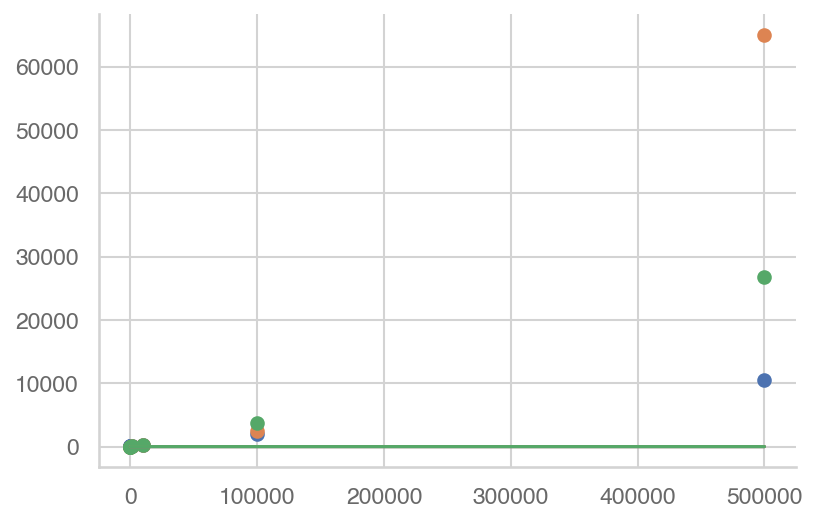

In [236]:
for experiment_name, means in one_to_many_performance_means.items():
    reg = regs[experiment_name]
    X = [[np.log(file_size), 8.] for file_size in means.keys()]
    X_scaled = StandardScaler().fit_transform(X)
    X_trans = poly.fit_transform(X_scaled)
    y = [y_val for y_val in means.values()]
    y_scaled = StandardScaler().fit_transform(np.array(y).reshape(-1,1))
    print(reg.score(X_trans, y_scaled))
    plt.scatter(means.keys(), y)
    plt.plot(means.keys(), np.power(np.e, reg.predict(X_trans)))

## Overhead Scaling with multiple consumers

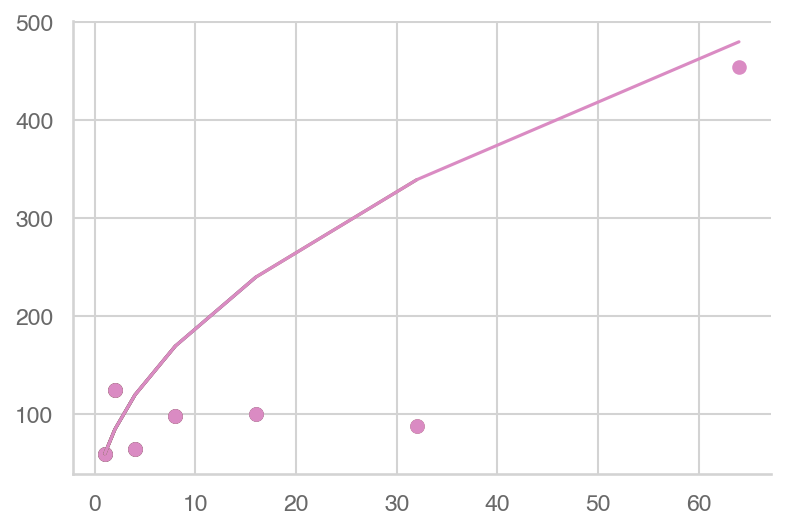

In [206]:
for experiment_name, exp_base_path in experiments.items():
    if experiment_name != "S3":
        continue
    experiment_base_folder = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out_overhead")
    data = {}
    for subf in os.scandir(experiment_base_folder):
        if subf.name != "256" and subf.name != "128" and int(subf.name) not in num_lambdas:
            num_lambdas.append(int(subf.name))
    for num_lambda in sorted(num_lambdas):
        var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out_overhead", str(num_lambda))
        res = parse_json(var_base_path)
        deltas = calc_deltas(res)
        run_means = [np.mean(run_data) for run_data in deltas[1000].values()]
        overall_mean = np.mean(run_means)
        data[num_lambda] = overall_mean
        plt.scatter(data.keys(), data.values())
        x = list(data.keys())
        y = [list(data.values())[0] * np.sqrt(x_val) for x_val in x]
        plt.plot(x, y)